In [1]:
import numpy as np
import pandas as pd
import torch
import random
import copy
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dquery = np.load("synthetic_query_v1.npy").astype(np.float32)
dval = np.load("synthetic_val_v1.npy").astype(np.float32)
dtest = np.load("synthetic_test_v1.npy").astype(np.float32)

In [3]:
dcf = np.load("synthetic-plaincf.npy").astype(np.float32)

In [4]:
query_x, query_y = dquery[:, 0:2], dquery[:, 2:3]
cf_x, cf_y = dcf[:, 0:2], np.round(1 - query_y).astype(np.float32)
val_x, val_y = dval[:, 0:2], dval[:, 2:3]
test_x, test_y = dtest[:, 0:2], dtest[:, 2:3]

In [5]:
scaler = MinMaxScaler()
query_x = scaler.fit_transform(query_x)
val_x = scaler.transform(val_x)
test_x = scaler.transform(test_x)
cf_x = scaler.fit_transform(cf_x)

# Select subset of query for training

In [6]:
a = list(range(len(query_x)))
random.shuffle(a)

In [7]:
idx = a[0:10]
query_sx, query_sy = query_x[idx], query_y[idx]
cf_sx, cf_sy = cf_x[0:10], cf_y[0:10]

train_x, train_y = np.concatenate((query_sx, cf_sx), axis = 0), np.concatenate((query_sy, cf_sy), axis = 0)

In [8]:
Query = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
Val = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
Test = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

In [9]:
query_loader = DataLoader(Query, batch_size  = 32)
val_loader = DataLoader(Val, batch_size = 32)
test_loader = DataLoader(Test, batch_size = 32)

In [10]:
print(dcf)

[[-0.38  2.12]
 [ 2.07  3.59]
 [ 5.49  4.77]
 ...
 [ 5.34  4.18]
 [ 0.64  3.03]
 [ 4.17  3.13]]


In [11]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    model.train()
    prediction = []
    label = []

    for batch_idx, (data, target) in enumerate(iterator):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        preds = torch.round(output)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * len(target)
        label.extend(target.tolist())
        prediction.extend(preds.reshape(-1).tolist())

    acc = accuracy_score(label, prediction)
    f1 = f1_score(label, prediction)

    return epoch_loss / len(iterator.dataset), acc, f1

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    model.eval()
    prediction = []
    label = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(iterator):

            data, target = data.to(device), target.to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            preds = torch.round(output)
            loss = criterion(output, target)
            epoch_loss += loss.item() * len(target)
            label.extend(target.tolist())
            prediction.extend(preds.reshape(-1).tolist())
            
    acc = accuracy_score(label, prediction)
    f1 = f1_score(label, prediction)

    return epoch_loss / len(iterator.dataset), acc, f1

In [12]:
model = nn.Sequential(
    nn.Linear(2, 20),
    nn.ReLU(),
    nn.Linear(20, 10),
    nn.ReLU(),
    nn.Linear(10, 1),
    nn.Sigmoid(),
)


optimizer = optim.Adam(model.parameters(), lr = 0.005)
criterion = nn.BCELoss()
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model = model.to(device)
criterion = criterion.to(device)

best_f1 = -float('inf')
best_model = None
best_acc = -float('inf')

for epoch in range(500):

    train_loss, train_acc, train_f1 = train(model, query_loader, optimizer, criterion, device)
    valid_loss, valid_acc, val_f1 = evaluate(model, test_loader, criterion, device)

    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model = copy.deepcopy(model)
        best_acc = valid_acc
    
    if epoch % 50 == 0:
        print(f'Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}')
        print(f'Epoch: {epoch} | Val. Loss: {valid_loss:.4f} |  Val. Acc: {valid_acc:.4f} |  Val. F1: {val_f1:.4f}')

print("Best Val. F1: {:.4f}, Best Val. Accuarcy: {:.4f}".format(best_f1, best_acc))

Epoch: 0 | Train Loss: 0.6937 | Train Acc: 0.5500 | Train F1: 0.7097
Epoch: 0 | Val. Loss: 0.6975 |  Val. Acc: 0.5337 |  Val. F1: 0.6960
Epoch: 50 | Train Loss: 0.5644 | Train Acc: 0.8000 | Train F1: 0.8462
Epoch: 50 | Val. Loss: 0.4525 |  Val. Acc: 0.8994 |  Val. F1: 0.9064
Epoch: 100 | Train Loss: 0.4179 | Train Acc: 0.8000 | Train F1: 0.8462
Epoch: 100 | Val. Loss: 0.2625 |  Val. Acc: 0.9117 |  Val. F1: 0.9126
Epoch: 150 | Train Loss: 0.3193 | Train Acc: 0.8500 | Train F1: 0.8696
Epoch: 150 | Val. Loss: 0.2777 |  Val. Acc: 0.8957 |  Val. F1: 0.8939
Epoch: 200 | Train Loss: 0.2353 | Train Acc: 0.8500 | Train F1: 0.8696
Epoch: 200 | Val. Loss: 0.3032 |  Val. Acc: 0.8896 |  Val. F1: 0.8866
Epoch: 250 | Train Loss: 0.1636 | Train Acc: 0.9500 | Train F1: 0.9565
Epoch: 250 | Val. Loss: 0.3870 |  Val. Acc: 0.7890 |  Val. F1: 0.7584
Epoch: 300 | Train Loss: 0.1091 | Train Acc: 1.0000 | Train F1: 1.0000
Epoch: 300 | Val. Loss: 0.5846 |  Val. Acc: 0.7276 |  Val. F1: 0.6667
Epoch: 350 | Train 

In [13]:
h= 0.02
x_min, x_max = dquery[:, 0].min() - .5, dquery[:, 0].max() + .5
y_min, y_max = dquery[:, 1].min() - .5, dquery[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                 np.arange(y_min, y_max, h))

In [14]:
dplot = np.c_[xx.ravel(), yy.ravel()]
_dplot = scaler.transform(dplot).astype(np.float32)
_dplot = torch.from_numpy(_dplot)
S = torch.round(best_model(_dplot)).detach().numpy()

In [15]:
S = S.reshape(xx.shape)

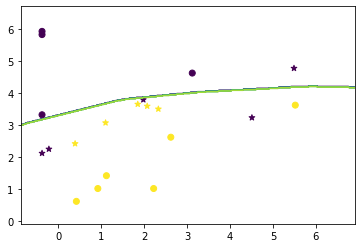

In [17]:
ax = plt.gca()
ax.contour(xx, yy, S)
ax.scatter(dcf[0:10, 0], dcf[0:10, 1], c = np.round(1 - dquery[0:10, 2]), marker = "*")
ax.scatter(dquery[idx, 0], dquery[idx, 1], c=dquery[idx, 2])
plt.show()